In [1]:
import torch,os
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 1000

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
use_cuda = torch.cuda.is_available()
softmax=torch.nn.Softmax()

In [3]:
class MLP:
    def __init__(self,in_features,out_features):
        self.L=torch.nn.Sequential(
            torch.nn.Linear(in_features=in_features,out_features=32,bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(32,64,bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(64,out_features=out_features,bias=True)
            )
    def forward_pass(self,X):
        return softmax(self.L(X))
    
    def accuracy(self,test_dataset):
        c=0
        for i in range(test_dataset.batch_size):
            if(torch.argmax(self.forward_pass(torch.flatten(test_dataset.dataset[i][0])))==test_dataset.dataset[i][1]):
                c+=1
        return c/test_dataset.batch_size
    
def onehotencoding(y):
    z=torch.zeros(10)
    z[y]=1
    return z

def conv(y):
    t=torch.argmax(y)
    z=torch.zeros(10)
    z[t]=1
    return z
    

In [4]:
model=MLP(784,10)
learning_rate=0.01
loss=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD([{"params":[model.L[0].weight,model.L[2].weight,model.L[4].weight,model.L[0].bias,model.L[2].bias,model.L[4].bias]}],lr=learning_rate)
n_iters=100
y_o=[]
for epoch in range(n_iters):
    for pts in range(train_loader.batch_size):
        optimizer.zero_grad()
        y_pred=model.forward_pass(torch.flatten(train_loader.dataset[pts][0]))
        l=loss(y_pred,onehotencoding(train_loader.dataset[pts][1]))
        l2_lambda = 0.001
        l2_norm = model.L[0].weight.pow(2.0).sum()+model.L[2].weight.pow(2.0).sum()+model.L[4].weight.pow(2.0).sum()+model.L[0].bias.pow(2.0).sum()+model.L[2].bias.pow(2.0).sum()+model.L[4].bias.pow(2.0).sum()
        l = l + l2_lambda * l2_norm
        l.backward()
        optimizer.step()
for pts in range(train_loader.batch_size):
    y_o.append(model.forward_pass(torch.flatten(train_loader.dataset[pts][0])).detach())


C:\Users\prana\AppData\Local\Temp\ipykernel_3664\3890395406.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(self.L(X))


In [5]:
print(model.accuracy(test_loader))
print(torch.argmax(model.forward_pass(torch.flatten(test_loader.dataset[3][0]))))
test_loader.dataset[3][1]

C:\Users\prana\AppData\Local\Temp\ipykernel_3664\3890395406.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(self.L(X))


0.784
tensor(0)


0

In [54]:
class decoder:
    def __init__(self,in_features,out_features):
        self.L=torch.nn.Sequential(
            torch.nn.Linear(in_features=in_features,out_features=32,bias=True),
            torch.nn.Linear(32,out_features=out_features,bias=True),
            torch.nn.Softmax()
            )
        
    def forward_pass(self,X):
        return 255*self.L(X)
    
    def loss(self,test_dataset,model):
        loss=0
        l=torch.nn.MSELoss()
        for i in range(test_dataset.batch_size):
            v=model.forward_pass(torch.flatten(test_dataset.dataset[i][0]).detach())
            tp=np.resize(self.forward_pass(v).detach().numpy(),(28,28))
            loss+=l(tp,test_dataset.dataset[i][0])
        return loss
            

In [55]:
model1=decoder(10,784)
learning_rate=0.1
loss=torch.nn.MSELoss()
optimizer=torch.optim.SGD([{"params":[model1.L[0].weight,model1.L[1].weight,model1.L[0].bias,model1.L[1].bias]}],lr=learning_rate)
n_iters=100
for epoch in range(n_iters):
    for pts in range(train_loader.batch_size):
        optimizer.zero_grad()
        y_pred1=model1.forward_pass(y_o[pts])
        l=loss(y_pred1,torch.flatten(train_loader.dataset[pts][0]))
        l.backward()
        optimizer.step()

c:\Users\prana\OneDrive\Desktop\IITHyderabad\codes\DL\Assign3\env\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1


C:\Users\prana\AppData\Local\Temp\ipykernel_3664\3890395406.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(self.L(X))


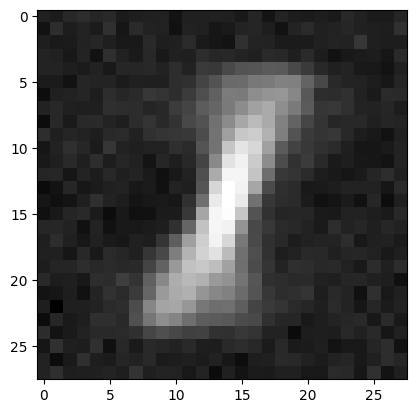

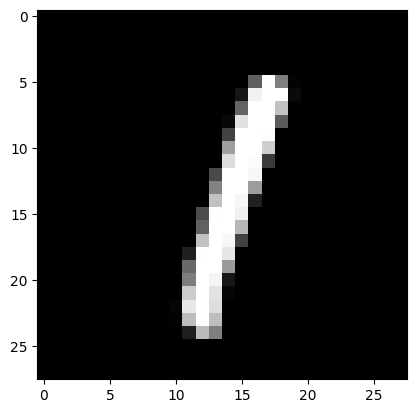

In [56]:
print(test_loader.dataset[5][1])
v=model.forward_pass(torch.flatten(test_loader.dataset[5][0]).detach())
tp=np.resize(model1.forward_pass(v).detach().numpy(),(28,28))
plt.imshow(tp,cmap='Greys_r')
plt.show()
plt.imshow(torch.squeeze(test_loader.dataset[5][0]).numpy(),cmap='Greys_r')